# Scan SOL10111

In [1]:
from impact import Impact, run_impact_with_distgen
from distgen import Generator

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

In [2]:
# Allows processes to work with macOS
from sys import platform
if platform == 'darwin':
    import multiprocessing as mp
    mp.set_start_method("fork")

# Initial setup and test

In [3]:
G = Generator('$FACET2_LATTICE/distgen/models/f2e_inj/v0/distgen.yaml')
G['n_particle']= 10000
G.run()
P0 = G.particles
P0

<ParticleGroup with 10000 particles at 0x1615ee3d0>

In [4]:
I0 = Impact.from_yaml('v0/ImpactT.yaml')
I0.stop

12.0

In [5]:
I0 = Impact.from_yaml('v0/ImpactT.yaml')
I0.verbose=True

I0.stop = 0.4
I0.run()

Removed element: stop_1
Set stop to s = 0.4
Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_1punnpu
/Users/chrisonian/Code/impact/impactT/bin/ImpactTv2.1_serial
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: 2.1 beta version
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           23          23
 pass setting up lattice...
 check randomness:            0  0.30440529327431320     
 avgpts, jlow, and jhigh:        10000           1       10000
 sumx1,sumy1:   -1.8066737280999832E-005  -1.3380017915800005E-005
 pass generating initial distribution...
 tstop:   0.40000000000000002     
 i,t,<z>:            1   0.0000000000000000        0.0000000000000000     
 zmin,zmax:    0.0000000000000000        5.2901005912554106E-006
 name: rfdataxrfdataxxrfdata201
 time:    0.0000000000000000, elapsed: 164.15774631500244Finished.

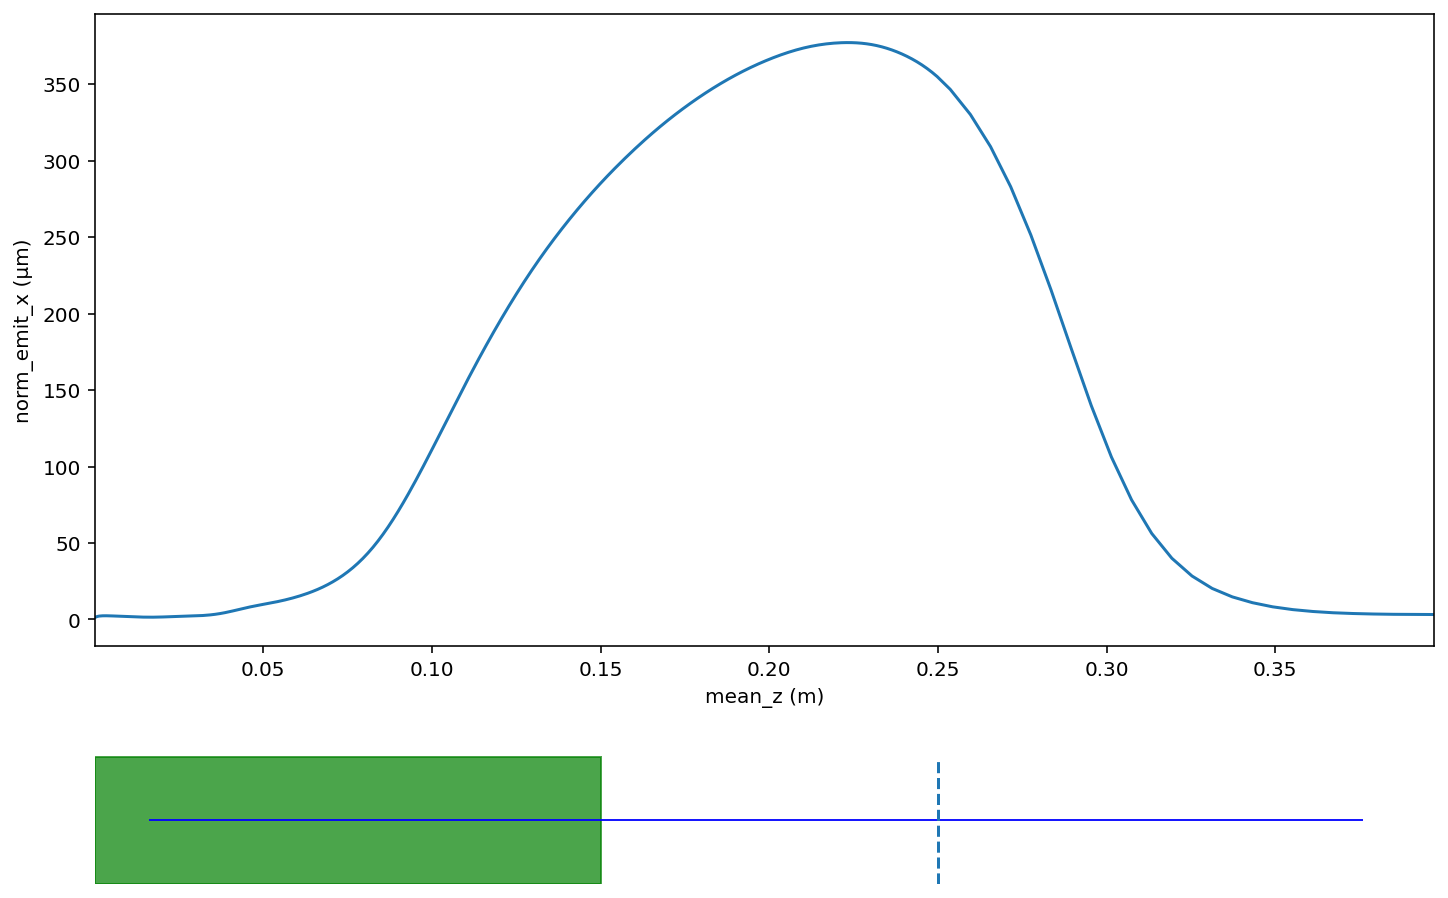

In [6]:
I0.plot('norm_emit_x')

In [7]:
I0['SOL10111:solenoid_field_scale']

0.23

# Scan `SOL10111:solenoid_field_scale`

In [14]:
%%time
def set_sol(scale):
    I = Impact.from_yaml('v0/ImpactT.yaml')
    I.initial_particles = P0
    I['SOL10111:solenoid_field_scale'] =scale
    I.stop = 4.1
    I.run()
    return I
    
set_sol(0.243)

CPU times: user 685 ms, sys: 132 ms, total: 816 ms
Wall time: 4min 58s


<Impact with 10000 particles, stopping at 4.1 m, at 0x160c778b0>

# Parallel

In [21]:
from concurrent.futures import ProcessPoolExecutor

In [22]:
# Scan list
xlist = np.linspace(0.24, 0.28, 8)
xlist 

array([0.24      , 0.24571429, 0.25142857, 0.25714286, 0.26285714,
       0.26857143, 0.27428571, 0.28      ])

In [23]:
%%time
with ProcessPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(set_sol, xlist))

CPU times: user 90 ms, sys: 134 ms, total: 224 ms
Wall time: 10min 30s


0.24 1066
0.24571428571428572 1066
0.25142857142857145 1066
0.2571428571428572 1066
0.26285714285714284 1066
0.26857142857142857 1066
0.2742857142857143 1066
0.28 1066


Text(0, 0.5, 'norm_emit_x (mm-mrad)')

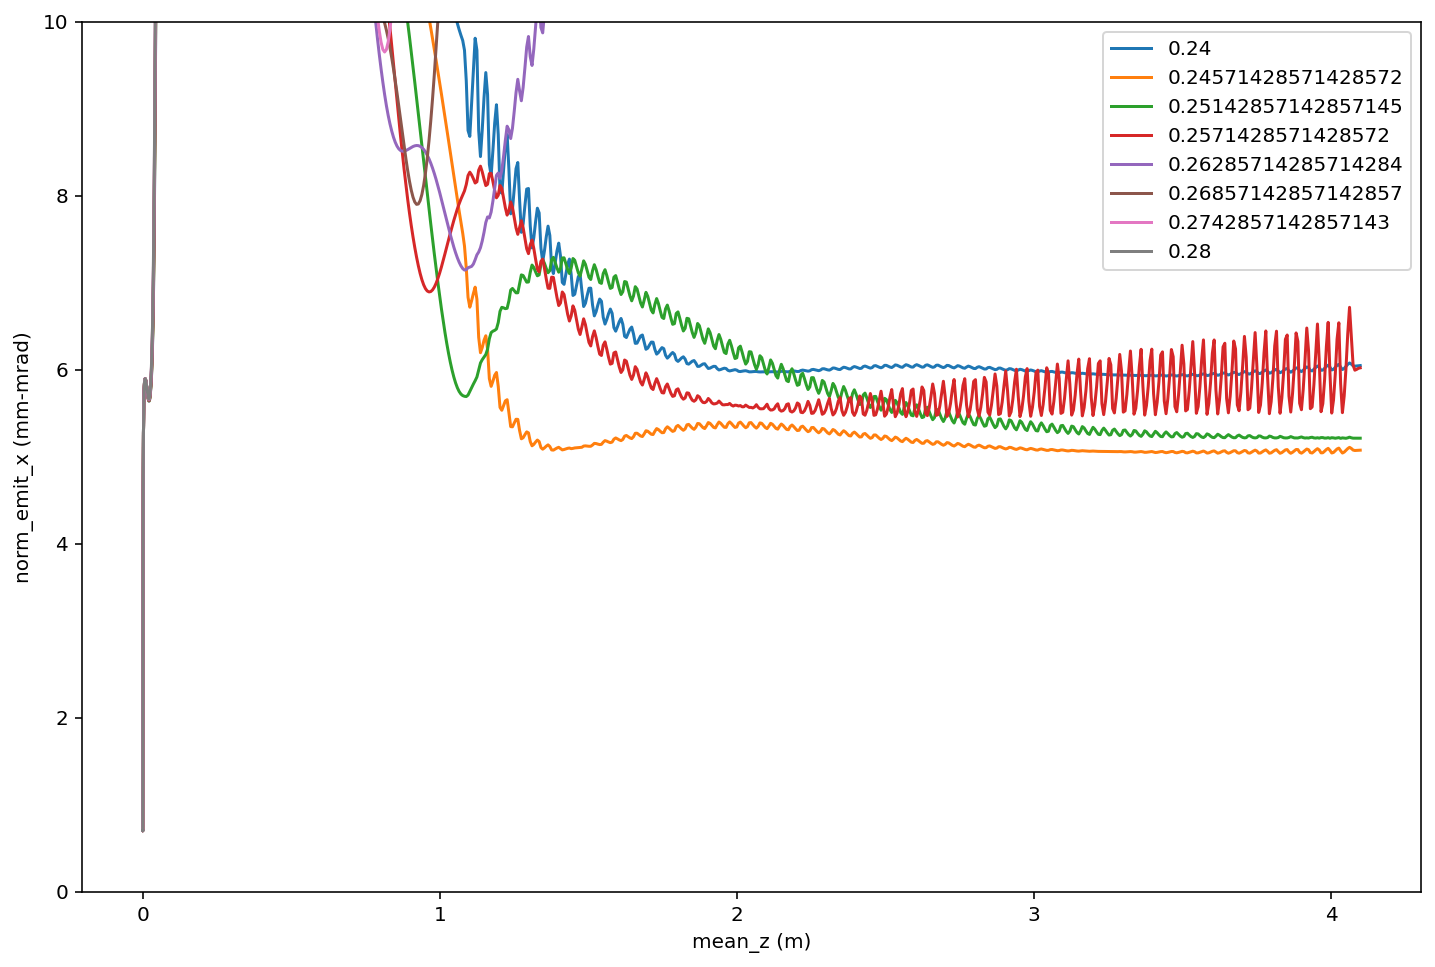

In [24]:
fig, ax = plt.subplots()

k1 = 'mean_z'
k2 = 'norm_emit_x'

f1 = 1
f2 = 1e6

for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)
    
ax.set_ylim(0, 10)    
ax.legend()    
ax.set_xlabel(k1 + ' (m)')
ax.set_ylabel(k2 + ' (mm-mrad)')
    

In [25]:
for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)

0.24 1066
0.24571428571428572 1066
0.25142857142857145 1066
0.2571428571428572 1066
0.26285714285714284 1066
0.26857142857142857 1066
0.2742857142857143 1066
0.28 1066


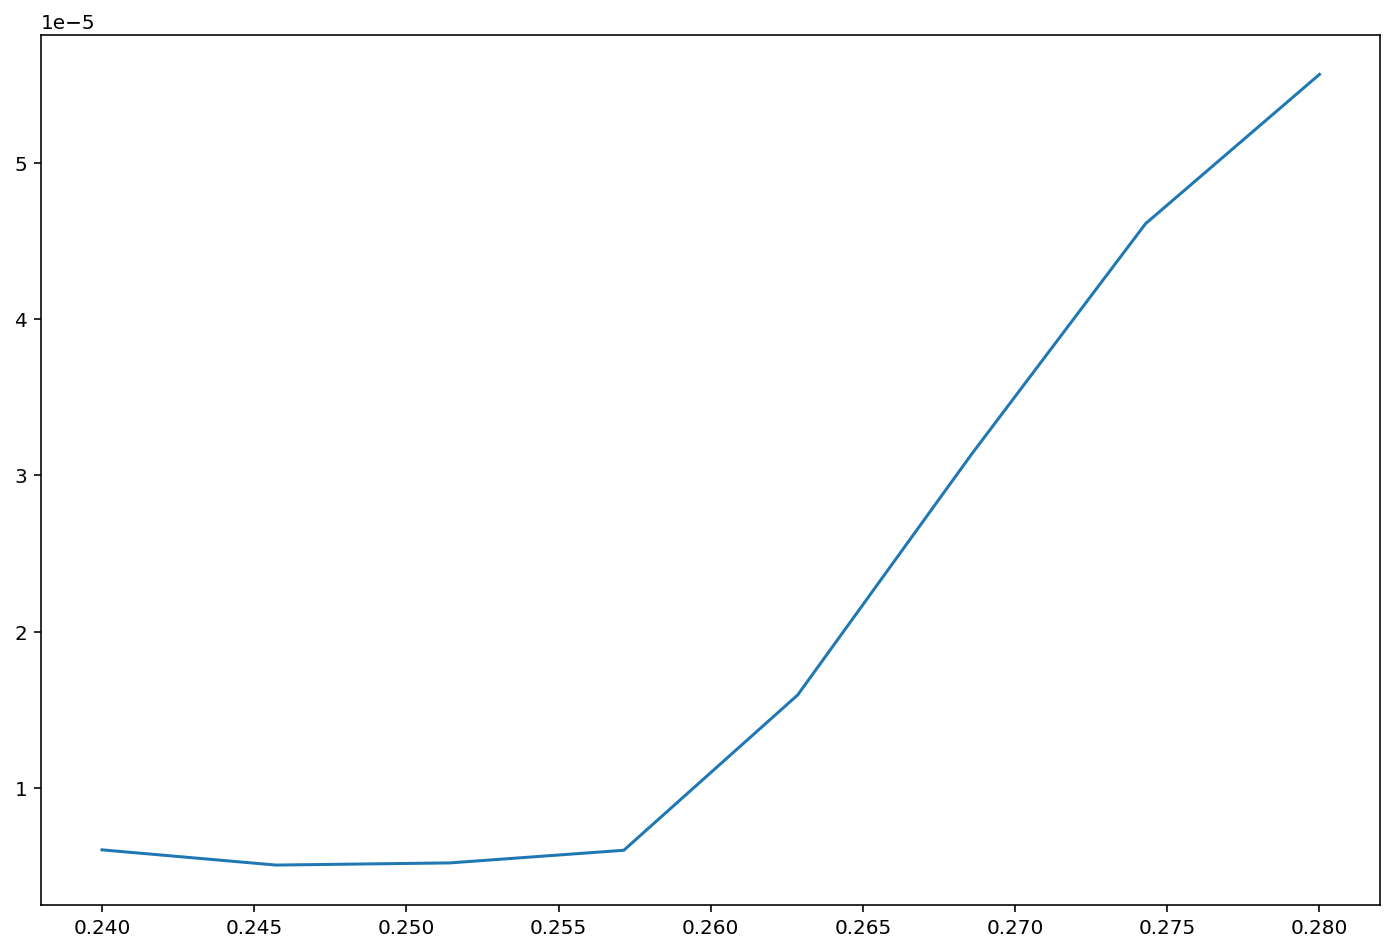

In [26]:
emits = [I.stat('norm_emit_x')[-1] for I in results]

plt.plot(xlist, emits)